# Figure 3: Random Forest and Transcription

### Load data and apply ChromaFactor

In [7]:
import sys
sys.path.append('code')  

from DeepLearningChromatinStructure_code import *  # Rajpurkar et al. ORCA processing code 
from plot import *                                 # Plotting functions for 2D and 3D data
from utils import *                                # Util functions for 2D and 3D data
from ChromaFactor import *                         # ChromaFactor
from file_utils import *                           # Enhancer/gene file processing 

In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


In [9]:
# data can be found here: https://zenodo.org/records/4741214

orca_dir = "/srv/home/lgunsalus/data/orca/"
dna_file = orca_dir + "dnaData_exp1.csv"
rna_file = orca_dir + "rnaData_exp1.csv"

In [10]:
xyzdat, rnadat = read_data(dna_file, rna_file) # read in data
xyzdat = fill_in_missing(xyzdat)               # fill in missing points with nas
xyzfilt, rnafilt = filter_dat(xyzdat, rnadat, req_xyz_perc = 0.2, interpol=True, norm = False, bool_thresh = 1)

In [11]:
all_maps = np.asarray([get_distance_matrix(single_map) for single_map in xyzfilt])
normalized = (all_maps-np.min(all_maps))/(np.max(all_maps)-np.min(all_maps))
median_distance_map_combined = np.nanmedian(normalized, axis = 0)
contact_th = 500
contact_map_combined = np.sum(all_maps<contact_th, axis=0) / np.sum(np.isnan(all_maps)==False, axis=0)

### Run

In [12]:
# Run ChromaFactor
chroma_factor = ChromaFactor(normalized)

# Reconstruct maps
new_maps = chroma_factor.reconstruct_maps()

# Measure reconstruction error
print(f"Reconstruction Error: {chroma_factor.reconstruction_err}")
components = chroma_factor.components

Reconstruction Error: 34.126570312148196


# Random Forest

In [15]:
# Define the list of RNA names
rna_list = [
    "AbdB_Main_Exon", "AbdB_Short_Exon", "AbdA_Exon", "Ubx_Exon", "Antp_Exon",
    "Scr_Exon", "Dfd_Exon", "pb_Exon", "lab_Exon", "Iab4_ncGene",
    "bxd_ncGene", "inv_Exon", "en_Whole_Gene", "ftz_Whole_Gene",
    "zen_Whole_Gene", "Ama_Whole_Gene", "sna_Whole_Gene", "elav_Exon",
    "AbdB_Main_Intron", "AbdB_Short_Intron", "AbdA_Intron", "Ubx_Intron",
    "Antp_Intron", "Scr_intron", "Dfd_Intron", "pb_Intron", "lab_Intron",
    "inv_Intron", "elav_Intron"
]


In [18]:
import warnings
warnings.filterwarnings('ignore')

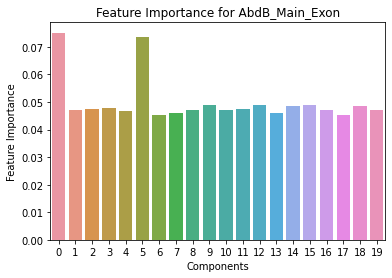

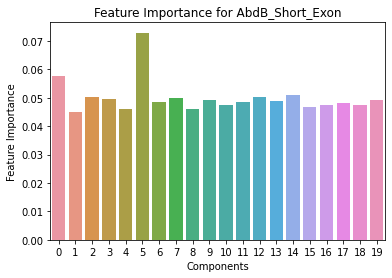

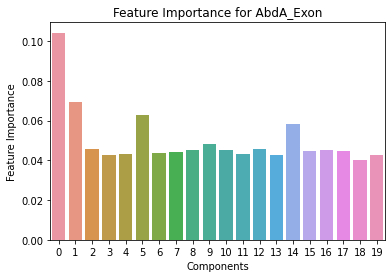

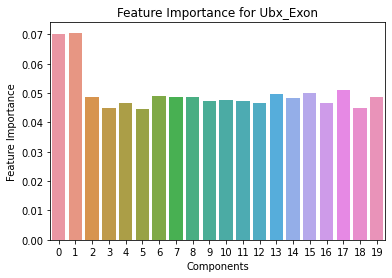

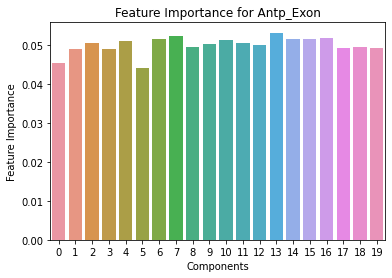

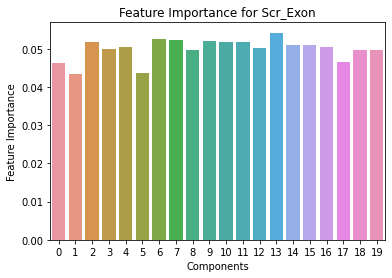

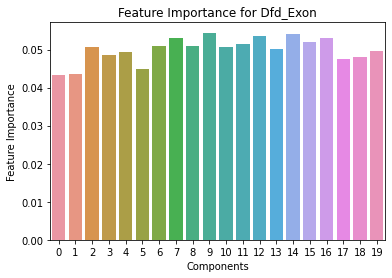

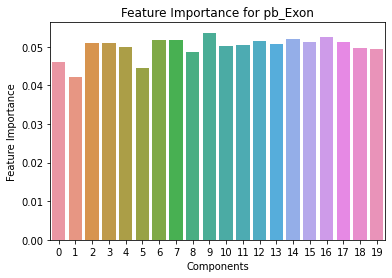

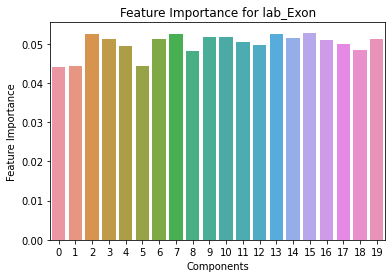

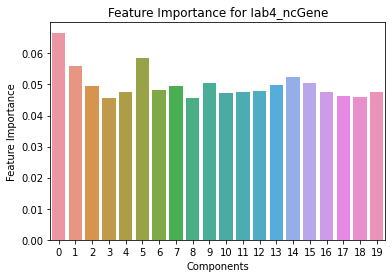

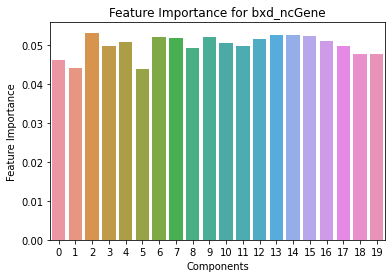

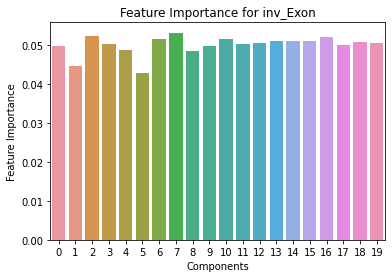

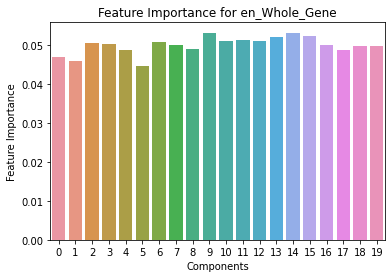

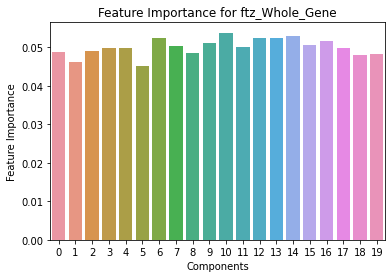

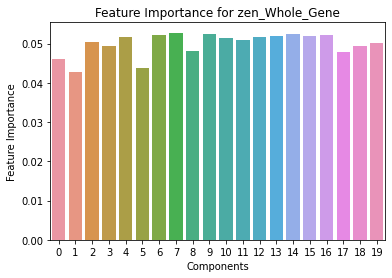

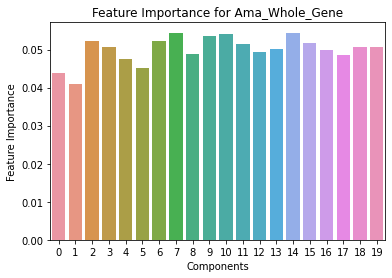

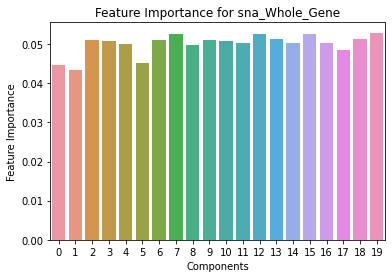

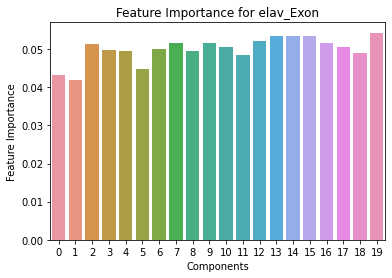

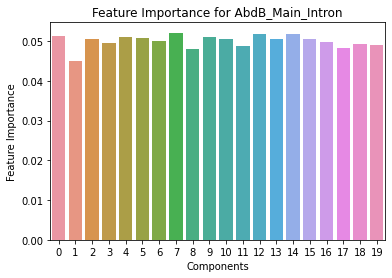

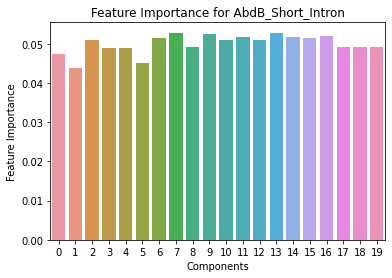

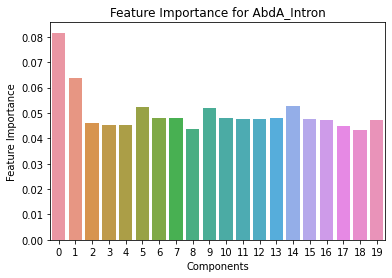

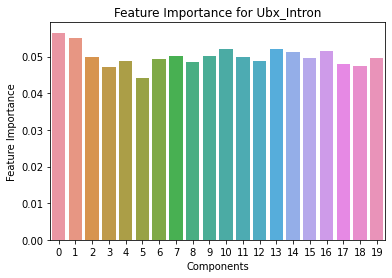

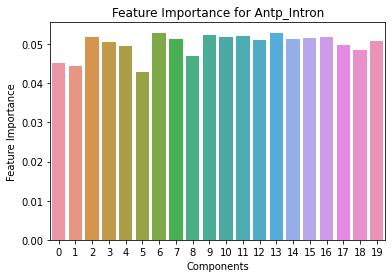

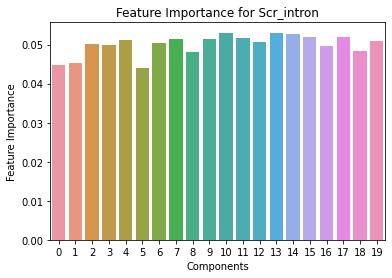

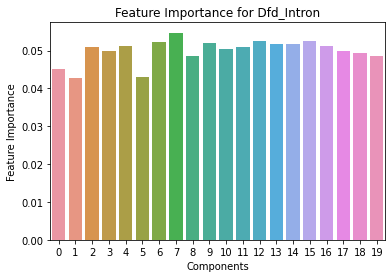

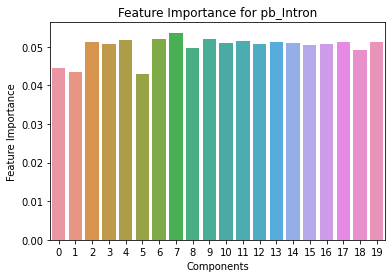

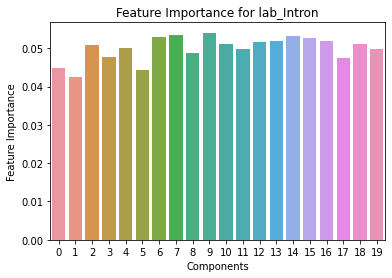

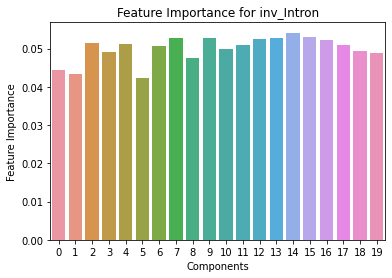

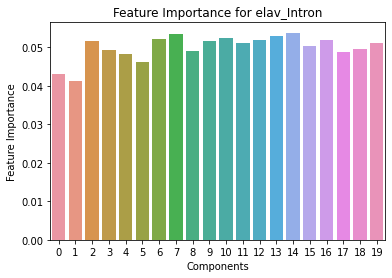

In [19]:
# Convert components to a DataFrame
component_df = pd.DataFrame(components.T)

# Create a mapping from RNA names to indices
rna_to_index = {rna: idx for idx, rna in enumerate(rna_list)}
index_to_rna = {idx: rna for idx, rna in enumerate(rna_list)}

# Initialize lists to store results
rna_results = []
examples_count = []
accuracy_scores = []
oob_scores = []
feature_importance_figures = []


# Loop through all RNAs
for rna_no, rna_name in enumerate(rna_list):
    X = components.T
    y = rnafilt.T[rna_no]
    X, y = balanced_subsample(X, y)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Normalize the training and testing data
    train_mean = np.mean(X_train)
    train_std = np.std(X_train)
    X_train = (X_train - train_mean) / train_std
    X_test = (X_test - train_mean) / train_std

    # Calculate the balance ratio
    balance = max(np.sum(y) / len(y), 1 - np.sum(y) / len(y))

    # Initialize the classifier
    clf = RandomForestClassifier(n_estimators=100, oob_score=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Collect results
    rna_results.append(rna_name)
    examples_count.append(X_train.shape[0])
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))
    oob_scores.append(clf.oob_score_)

    # Plot feature importance
    feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
    sns.barplot(x=feature_imp.index, y=feature_imp)
    plt.xlabel('Components')
    plt.ylabel('Feature Importance')
    plt.title(f"Feature Importance for {rna_name}")
    plt.legend().remove()  # Remove legend if not necessary
    plt.show()


# Performance

In [21]:
feature_imp = pd.Series(accuracy_scores,
                  index=rna_list).sort_values(ascending=False)


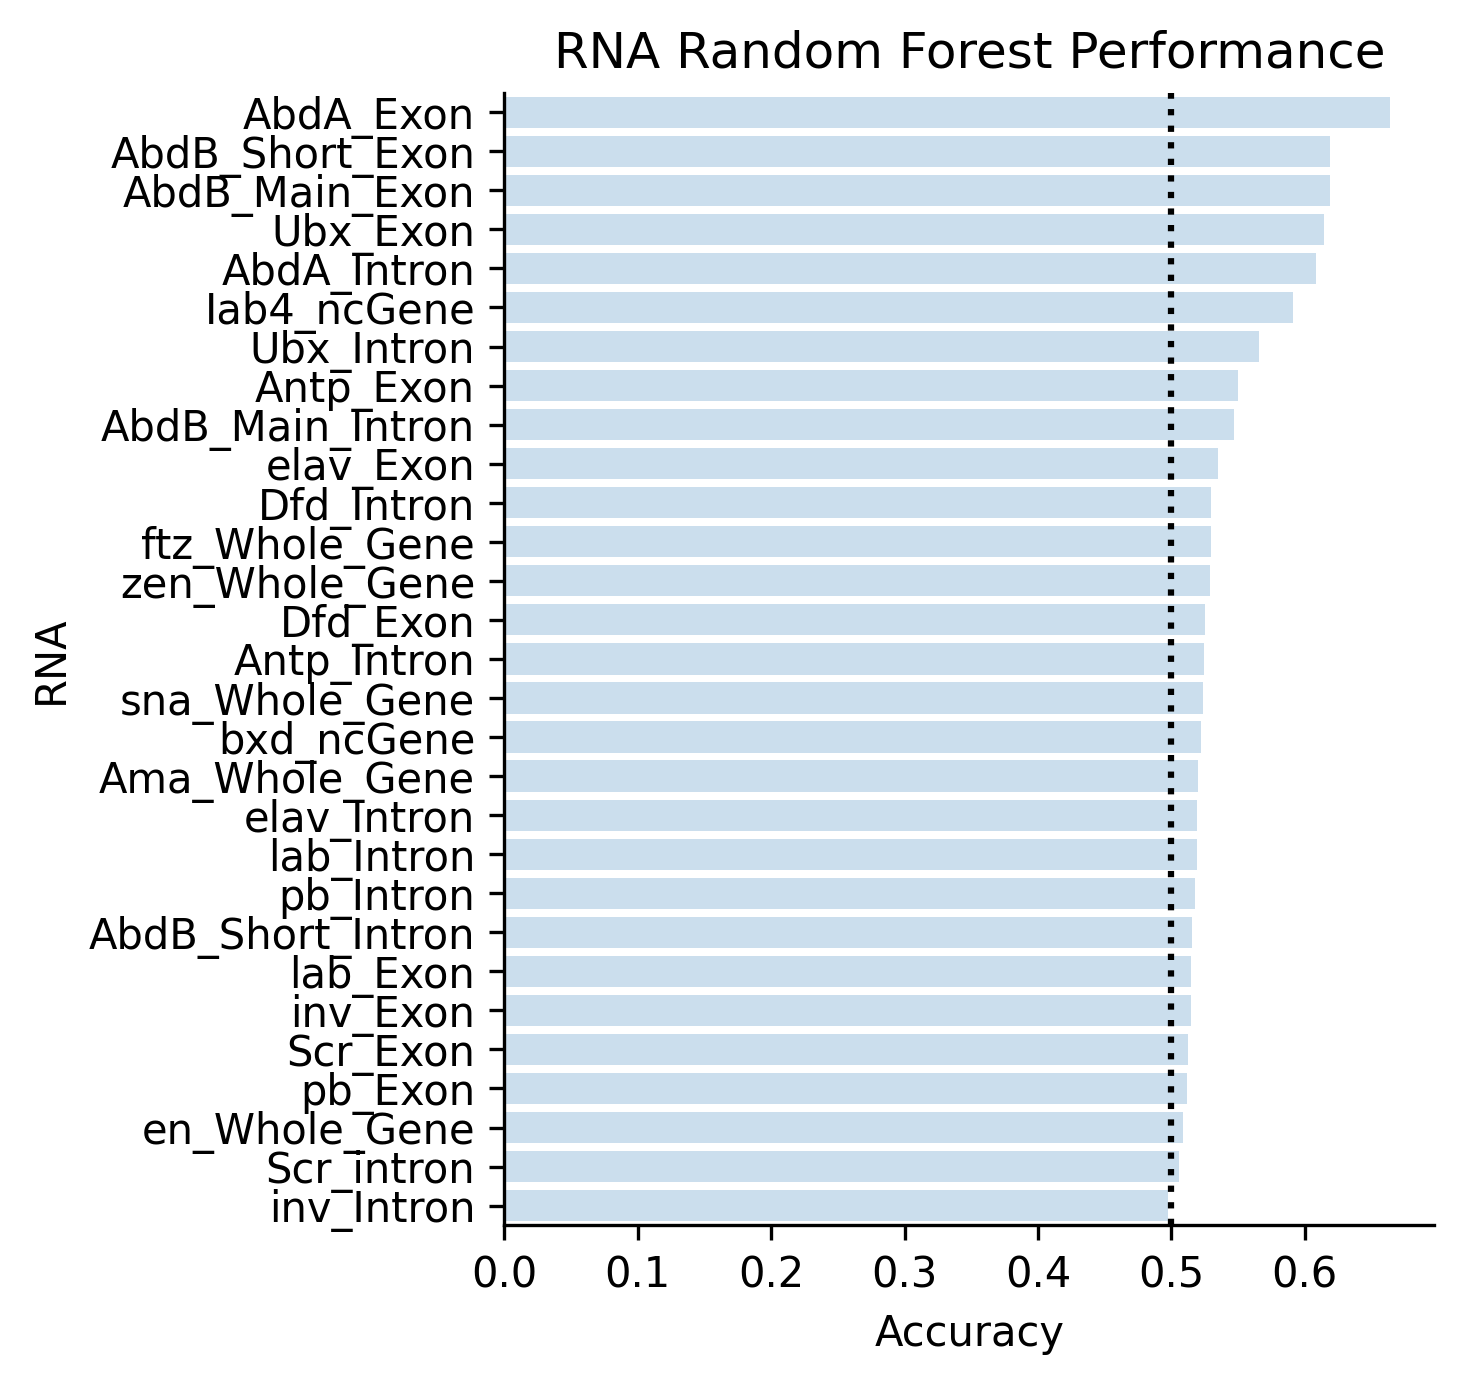

In [24]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

figure(figsize=(4,5), dpi=300)

feature_imp = pd.Series(accuracy_scores,
                        index=rna_list).sort_values(ascending=False)

sns.barplot(y=feature_imp.index, x = feature_imp, 
            #palette="coolwarm_r",
            color = '#C5DFF3',
            orientation='horizontal')
plt.axvline(x=0.5, color='black', linestyle=':')
plt.xlabel('Accuracy')
plt.ylabel('RNA')
plt.title("RNA Random Forest Performance")
plt.show()

# Feature importance

In [27]:
rna_no = rna_to_index['AbdA_Exon']
X = components.T
y = rnafilt.T[rna_no]
X, y = balanced_subsample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

# normalize
train_mean = np.mean(X_train)
train_std = np.std(X_train)
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std


balance = max(np.sum(y)/len(y), 1-np.sum(y)/len(y))

clf=RandomForestClassifier(n_estimators=100, oob_score=True)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print(f"RNA: {rna_no}")
print(f"Training Examples: {X_train.shape[0]}")
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4))
print("oob:",round(clf.oob_score_, 4))
print("balance:",round(balance, 4))
print("-------------")


RNA: 2
Training Examples: 7502
Accuracy: 0.6775
oob: 0.66
balance: 0.5
-------------


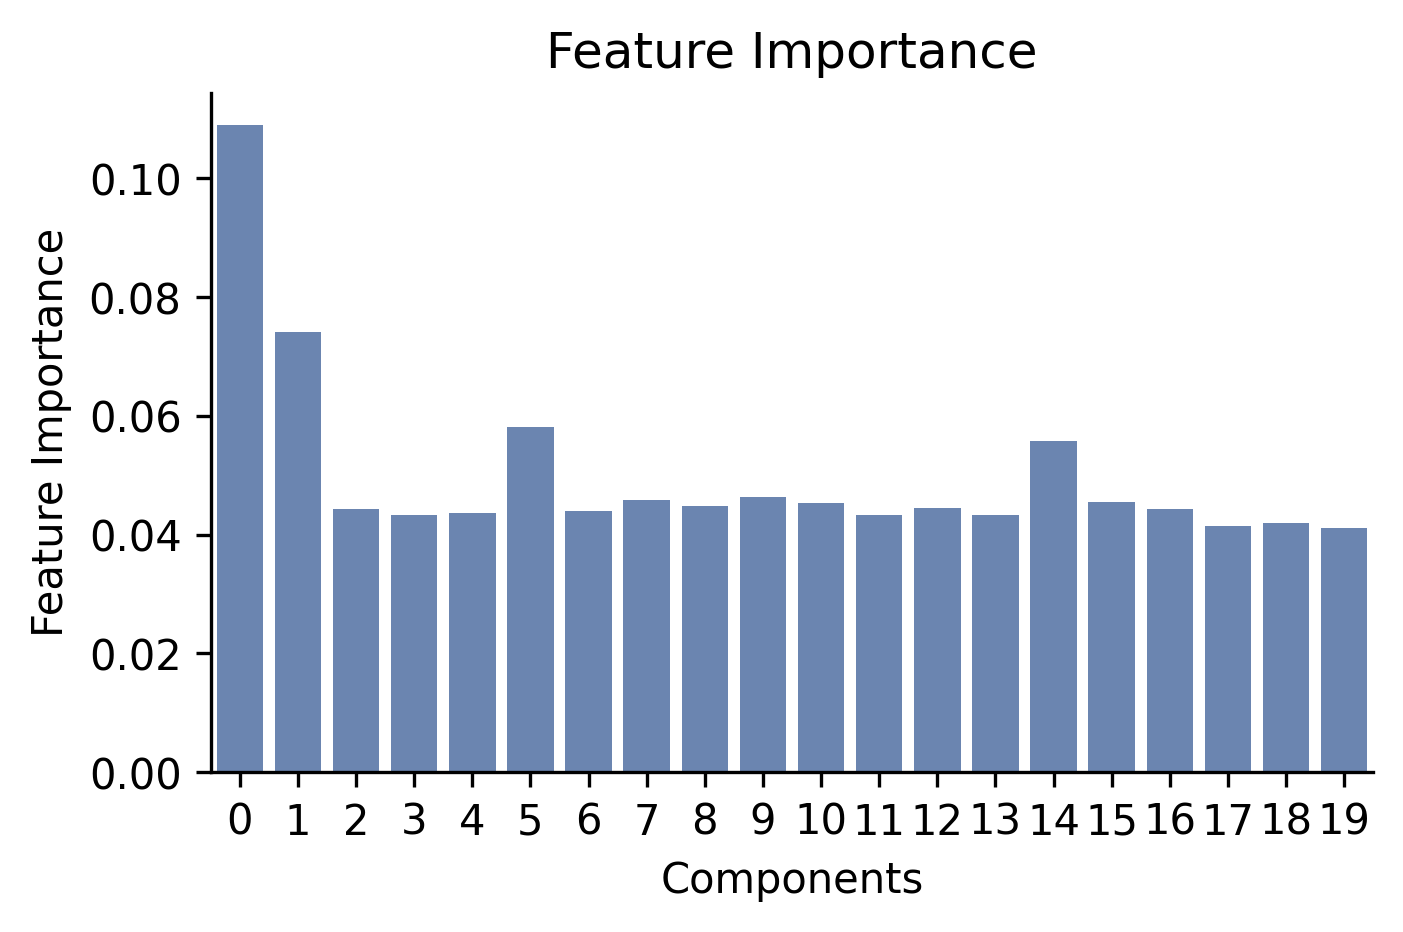

In [28]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

figure(figsize=(5,3), dpi=300)

feature_imp = pd.Series(clf.feature_importances_,index=list(range(components.shape[0]))).sort_values(ascending=False)

sns.barplot(x=feature_imp.index, y = feature_imp, color = '#5F83BB')

plt.xlabel('Components')
plt.ylabel('Feature Importance')
plt.title("Feature Importance")

plt.show()

# Component significance

In [36]:
componentF = pd.DataFrame(components.T)

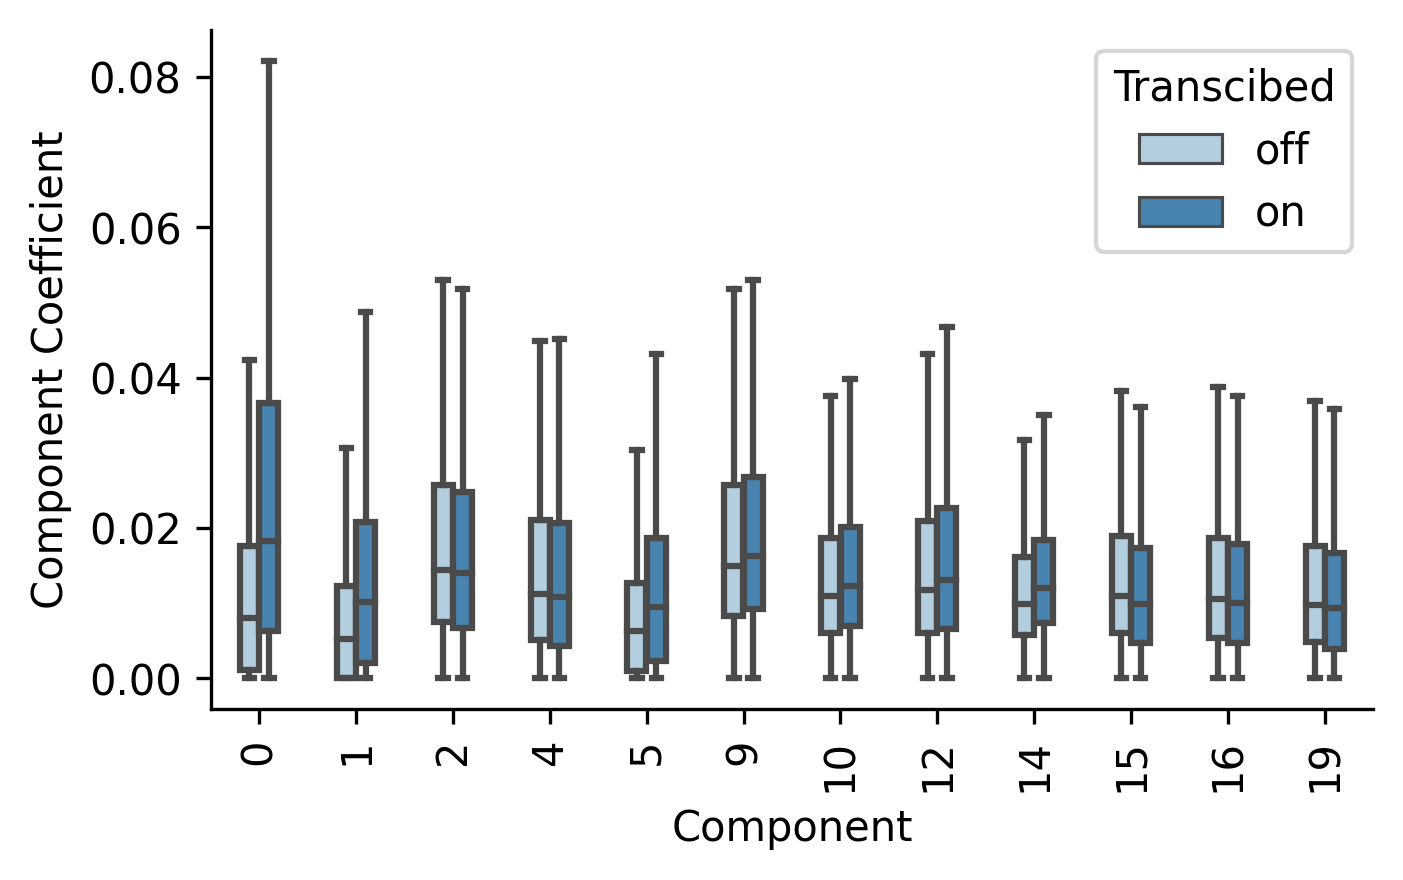

In [35]:
alpha =.001 # significance threshold

X = components
y = rnafilt.T[rna_no]

df = componentF
df["Cell_State"] = y

import scipy.stats as stats

# # Threshold for significance
# alpha = 0.05/30

# List to hold significantly different components
significant_components = []
pvals = []

# Perform Manan-Whitney U test for each component
for component in df.columns[:-1]:  # Exclude the "Cell_State" column
    positive_values = df[df["Cell_State"] == 1][component]
    negative_values = df[df["Cell_State"] == 0][component]
    
    # Perform the test
    _, p_value = stats.mannwhitneyu(positive_values, negative_values, alternative='two-sided')

    # If the p-value is less than alpha, the difference is significant
    if p_value < alpha:
        significant_components.append(component)
        pvals.append(p_value)

# Filter the DataFrame to include only significant components
df_significant = df[significant_components + ["Cell_State"]]

# Convert DataFrame from wide to long format for easy plotting
df_melted = pd.melt(df_significant, id_vars="Cell_State", var_name="Component", value_name="Value")


df_melted['Cell_State'] = df_melted['Cell_State'].replace({0: 'off', 1: 'on'})

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

figure(figsize=(5,3), dpi=300)

# Create the boxplot
ax = sns.boxplot(data=df_melted, x="Component", y="Value", hue="Cell_State", showfliers=False,
                 width=0.4,
             palette="Blues")

plt.gcf().set_facecolor('none')

plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.ylabel('Component Coefficient')
plt.show()


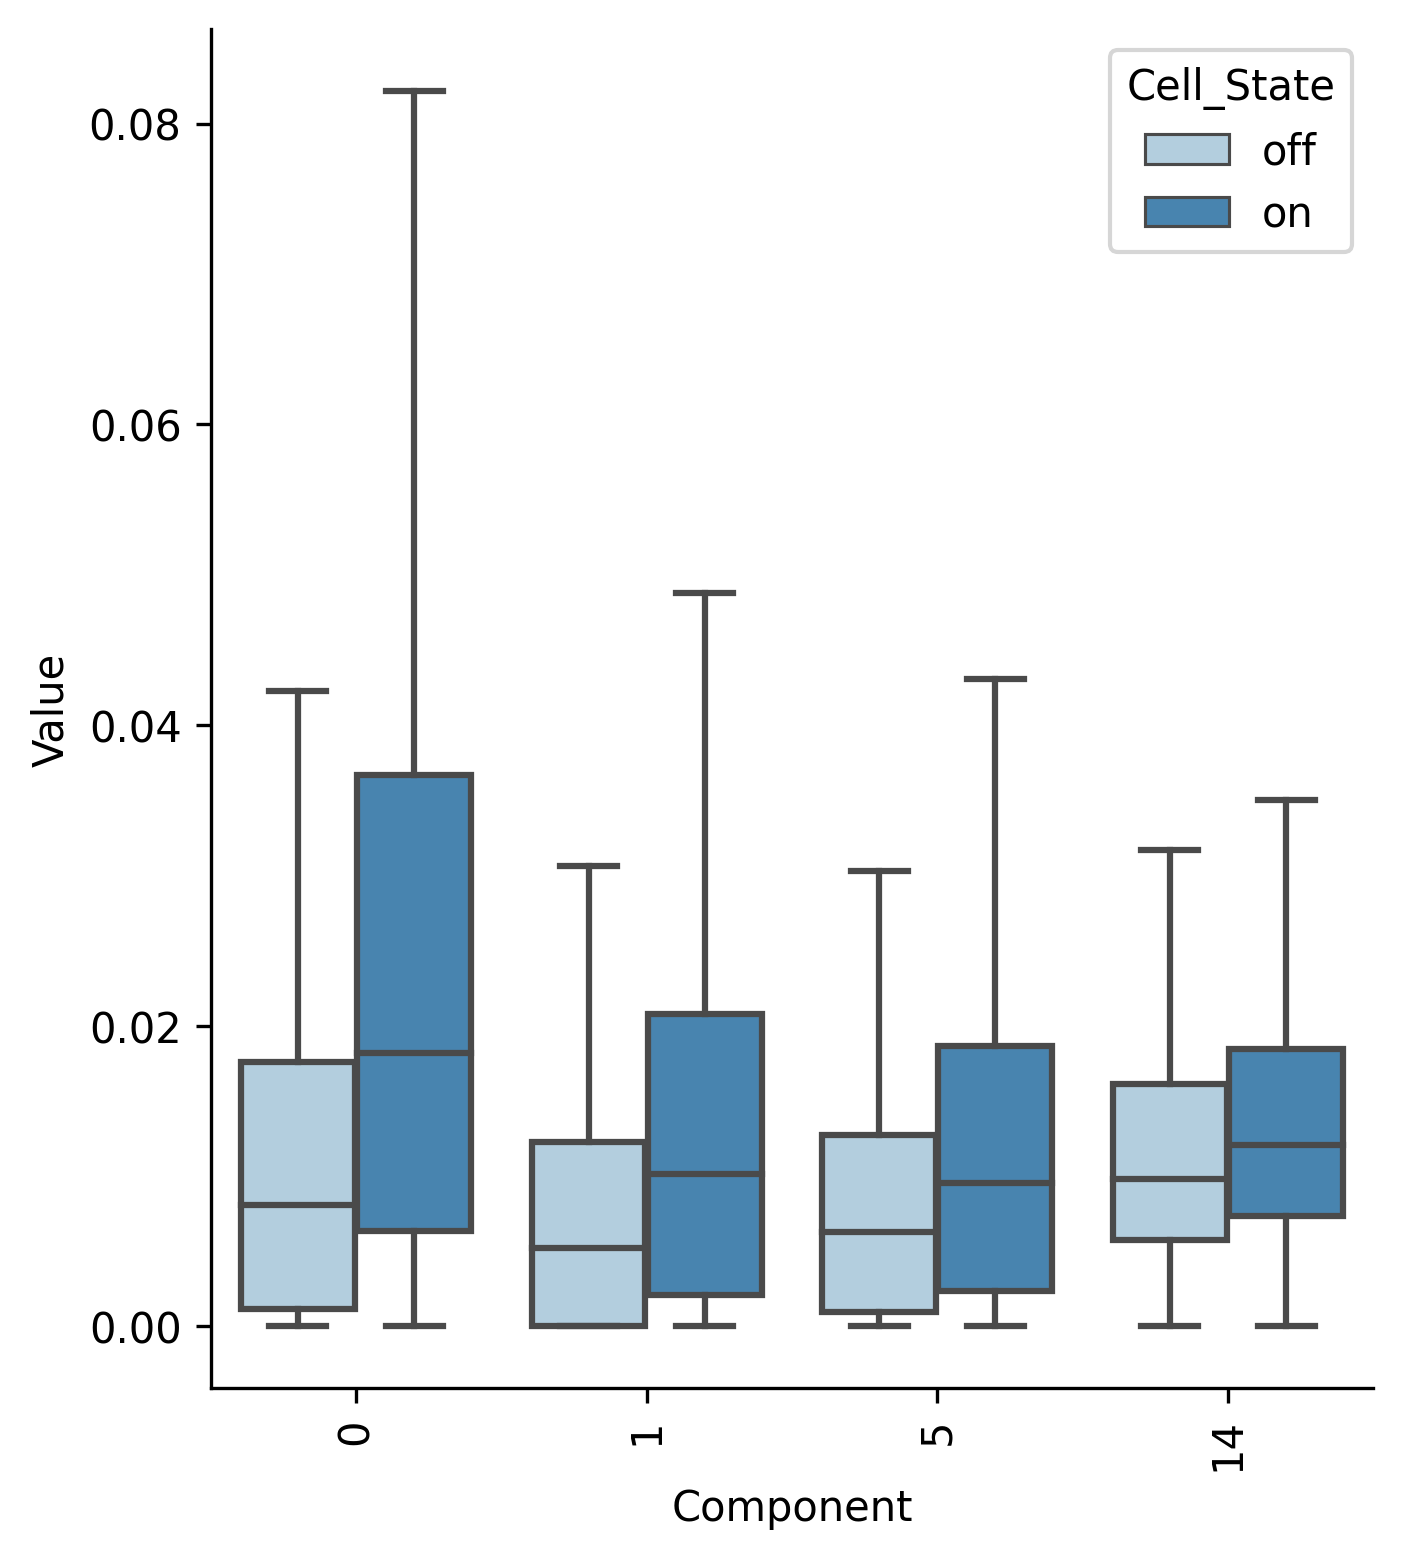

In [37]:
alpha = 0.00000000000000000000000000001 # significance threshold

X = components
y = rnafilt.T[rna_no]

df = componentF
df["Cell_State"] = y

import scipy.stats as stats

# List to hold significantly different components
significant_components = []
pvals = []

# Perform Manan-Whitney U test for each component
for component in df.columns[:-1]:  # Exclude the "Cell_State" column
    positive_values = df[df["Cell_State"] == 1][component]
    negative_values = df[df["Cell_State"] == 0][component]
    
    # Perform the test
    _, p_value = stats.mannwhitneyu(positive_values, negative_values, alternative='two-sided')

    # If the p-value is less than alpha, the difference is significant
    if p_value < alpha:
        significant_components.append(component)
        pvals.append(p_value)

# Filter the DataFrame to include only significant components
df_significant = df[significant_components + ["Cell_State"]]

# Convert DataFrame from wide to long format for easy plotting
df_melted = pd.melt(df_significant, id_vars="Cell_State", var_name="Component", value_name="Value")


df_melted['Cell_State'] = df_melted['Cell_State'].replace({0: 'off', 1: 'on'})

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

figure(figsize=(5,6), dpi=300)

# Create the boxplot
ax = sns.boxplot(data=df_melted, x="Component", y="Value", hue="Cell_State", showfliers=False,
           palette="Blues")

plt.gcf().set_facecolor('none')

plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()


## Color UMAP

In [39]:
umap = pd.read_csv('umap_plot.csv')
concatF = pd.concat([umap, componentF], axis=1)
concatF['hue'] = 'none'
neg_index = concatF[(concatF[0] < 0.009631) & (concatF[1] < 0.006144) & (concatF[5] < 0.006813) & (concatF[14] < 0.010290)].index
concatF.loc[neg_index,'hue'] = 'off'
pos_index = concatF[(concatF[0] > 0.009631) & (concatF[1] > 0.006144) & (concatF[5] > 0.006813) & (concatF[14] > 0.010290)].index
concatF.loc[pos_index,'hue'] = 'on'


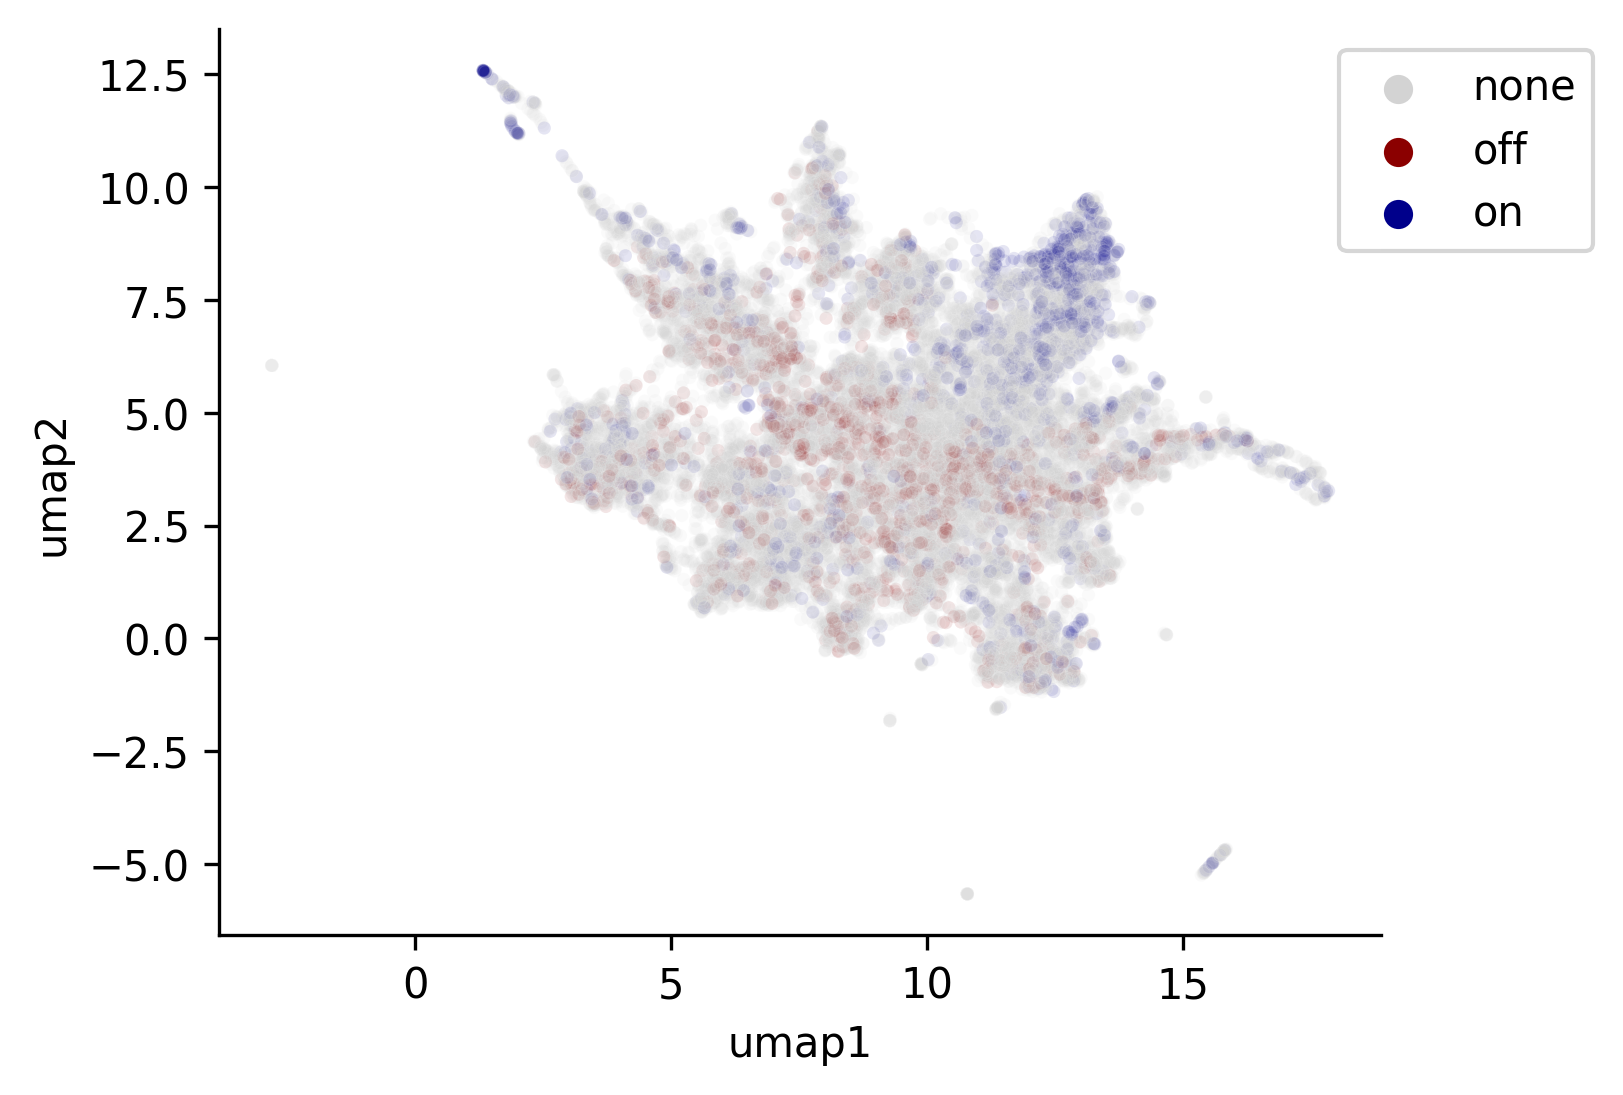

In [41]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig = plt.figure(figsize = (5,4), dpi=300)


palette = {'none': 'lightgrey', 'on': 'darkblue', 'off': 'darkred'}

g = sns.scatterplot(data=concatF, x = 'umap1', y = 'umap2',hue='hue', 
                palette=palette, alpha= .1, s=10)
g.legend(bbox_to_anchor= (1.2,1))


plt.show()

## Plot highest and lowest contribution cells

In [42]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

### Off

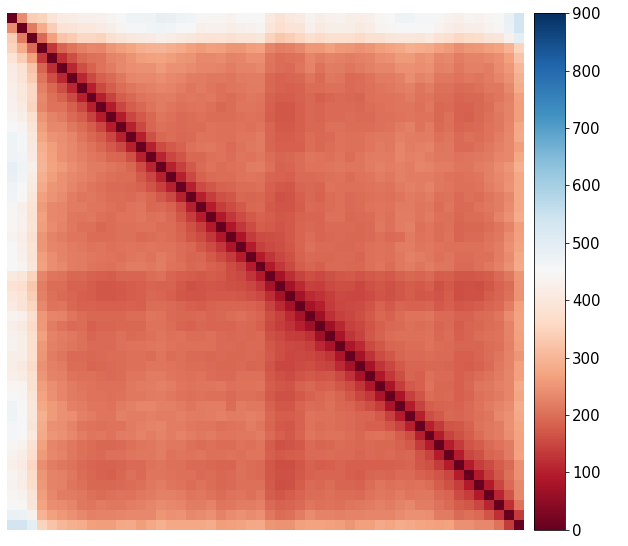

In [48]:
cur_component = 'off'
component_mask = concatF['hue'] == cur_component
component_maps = all_maps[component_mask]
component_maps_reshape_on = np.asarray([get_distance_matrix(single_map) for single_map in component_maps])
neg_component_median = np.nanmedian(component_maps_reshape_on, axis = 0)
plot_distance_matrix(neg_component_median, cmap_order='forward',hide_all=True, ax_label=None,
                                                         vmax = 900,
                                                            colorbar_labels=' ')

### On

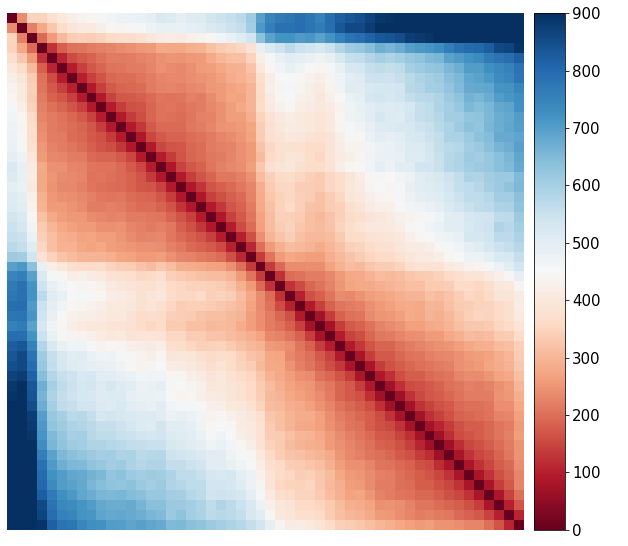

In [51]:
cur_component = 'on'
component_mask = concatF['hue'] == cur_component
component_maps = all_maps[component_mask]
component_maps_reshape_off = np.asarray([get_distance_matrix(single_map) for single_map in component_maps])
pos_component_median = np.nanmedian(component_maps_reshape_off, axis = 0)
plot_distance_matrix(pos_component_median, cmap_order='forward',hide_all=True, ax_label=None,
                                                                              vmax = 900,
                                                            colorbar_labels=' ')

# Enhancer distance

In [ ]:
# Define a list of RNA names for various genetic elements.
rna_list = [
    "AbdB_Main_Exon", "AbdB_Short_Exon", "AbdA_Exon", "Ubx_Exon", "Antp_Exon",
    "Scr_Exon", "Dfd_Exon", "pb_Exon", "lab_Exon", "Iab4_ncGene", "bxd_ncGene",
    "inv_Exon", "en_Whole_Gene", "ftz_Whole_Gene", "zen_Whole_Gene",
    "Ama_Whole_Gene", "sna_Whole_Gene", "elav_Exon", "AbdB_Main_Intron",
    "AbdB_Short_Intron", "AbdA_Intron", "Ubx_Intron", "Antp_Intron", "Scr_intron",
    "Dfd_Intron", "pb_Intron", "lab_Intron", "inv_Intron", "elav_Intron"
]

# Create a dictionary mapping RNA names to a unique index.
rna_to_index = dict(zip(rna_list, range(len(rna_list))))
# Create a dictionary mapping indices back to RNA names for lookup.
index_to_rna = {index: rna for index, rna in enumerate(rna_list)}

# Calculate distance matrices for a filtered set of coordinates (xyzfilt) and
# convert the results into a numpy array.
all_maps = np.asarray([get_distance_matrix(single_map) for single_map in xyzfilt])
# Normalize the distance matrices by scaling the data between 0 and 1.
normalized = (all_maps - np.min(all_maps)) / (np.max(all_maps) - np.min(all_maps))

# Select a specific RNA by its name ('AbdA_Exon') and extract the corresponding filtered data.
rna_no = rna_to_index['AbdA_Exon']
y = rnafilt.T[rna_no]
# Create boolean masks for selecting positive and negative data points.
positive_mask = np.array(y, dtype=bool)
negative_mask = ~positive_mask

# Apply the masks to separate the normalized maps into positive and negative subsets.
positive_maps = normalized[positive_mask]
negative_maps = normalized[negative_mask]

# Define file paths for various genomic feature annotations.
loc = '/srv/home/lgunsalus/data/orca/beds/BXC_10kb_track.bed'
probe_loc = "/srv/home/lgunsalus/data/orca/beds/BXC_3kb_orig52_track.bed"
abd = "/srv/home/lgunsalus/data/orca/beds/Abd_2.5kb_track.bed"
domains = "/srv/home/lgunsalus/data/orca/beds/BXC_domains_track.bed"
enhancers = "/srv/home/lgunsalus/data/orca/beds/BXC_enhancers_track.bed"
insulators = "/srv/home/lgunsalus/data/orca/beds/BXC_insulators_track.bed"
PRE = "/srv/home/lgunsalus/data/orca/beds/BXC_PREs_track.bed"

# Read in various annotation tracks from BED files into pandas DataFrames.
trackF = pd.read_csv(probe_loc, sep="\t", header=None, 
                     names=["chrom", "start", "stop", "probe", "x", "y", "z", "h", "rgb"])
abdF = pd.read_csv(abd, sep="\t", header=None, 
                   names=["chrom", "start", "stop", "probe", "x", "y", "z", "h", "rgb"])
domainsF = pd.read_csv(domains, sep="\t", header=None, 
                       names=["chrom", "start", "stop", "probe", "x", "y", "z", "h", "rgb"])
insulatorsF = pd.read_csv(insulators, sep="\t", header=None, 
                          names=["chrom", "start", "stop", "enhancer", "one", "plus", "st", "stp", "rgb"])
enhancersF = pd.read_csv(enhancers, sep="\t", header=None, 
                         names=["chrom", "start", "stop", "enhancer", "one", "plus", "st", "stp", "rgb"])

# Define directory for gene reference data.
gene_dir = "/srv/home/lgunsalus/data/orca/reference/"
# Concatenate directory with file names to create file paths for gene data.
ensGene = gene_dir + 'dm3.ensGene.gtf'
refGene = gene_dir + "dm3.refGene.gtf"

# Parse gene data files into pandas DataFrames.
ref_gene_parsed = dataframe(refGene)
ens_gene_parsed = dataframe(ensGene)


In [58]:
orca_seq = np.unique(trackF.chrom)[0]
orca_start = np.min(trackF.start.values)
orca_stop = np.max(trackF.stop.values)
orca_seq, orca_start, orca_stop

('chr3R', 12471574, 12786626)

In [60]:
# Retrieve index values from the 'trackF' DataFrame to form a list of probe identifiers.
probe_list = trackF.index.values
# Define a list of specific enhancer names of interest.
enhancer_list = ['Ubx-S1', 'Ubx-S2']

# Initialize the 'annotation' column in 'trackF' DataFrame to store enhancer locations.
trackF['annotation'] = None
# Apply a function to map enhancer locations onto the 'trackF' DataFrame.
enhancersF.apply(lambda x: map_probe_locations(x['start'], x['stop'], x['enhancer']), axis=1)

# Create a boolean list to check if the annotations in 'trackF' match those in the enhancer list.
enhancer_bool = [cur_enhancer in enhancer_list for cur_enhancer in trackF['annotation'].values]
# Assign colors based on the presence of enhancers of interest.
color_map = ['rgb(203, 44, 10)' if cur_val else 'rgb(155, 162, 174)' for cur_val in enhancer_bool]

# Add a 'probe_no' column to 'trackF' as a duplicate of the index for identification.
trackF['probe_no'] = trackF.index

# Initialize 'bin_no' columns in enhancer and gene DataFrames to prepare for mapping.
enhancersF['bin_no'] = None
ref_gene_parsed['bin_no'] = None
ens_gene_parsed['bin_no'] = None

# Standardize column names for the stop location across different DataFrames.
ref_gene_parsed['stop'] = ref_gene_parsed['end']
ens_gene_parsed['stop'] = ens_gene_parsed['end']

# Determine the minimum and maximum probe locations and the chromosome from 'trackF'.
min_orca_loc = np.min(trackF.start.values)
max_orca_loc = np.max(trackF.stop.values)
orca_chrom = trackF.chrom.values[0]

# Convert start and stop positions to integers for consistency in 'ref_gene_parsed'.
ref_gene_parsed['start'] = ref_gene_parsed['start'].astype(int)
ref_gene_parsed['stop'] = ref_gene_parsed['stop'].astype(int)

# Filter 'ref_gene_parsed' to only include entries within the specified chromosome and location range.
ref_gene_parsed = ref_gene_parsed[ref_gene_parsed['seqname'] == orca_chrom]
ref_gene_parsed = ref_gene_parsed[ref_gene_parsed['stop'] <= max_orca_loc]
ref_gene_parsed = ref_gene_parsed[ref_gene_parsed['start'] >= min_orca_loc]
# Further filter 'ref_gene_parsed' to only include transcript features.
ref_gene_parsed = ref_gene_parsed[ref_gene_parsed['feature'] == 'transcript']

# Perform similar filtering for 'ens_gene_parsed' as done for 'ref_gene_parsed'.
ens_gene_parsed['start'] = ens_gene_parsed['start'].astype(int)
ens_gene_parsed['stop'] = ens_gene_parsed['stop'].astype(int)

ens_gene_parsed = ens_gene_parsed[ens_gene_parsed['seqname'] == orca_chrom]
ens_gene_parsed = ens_gene_parsed[ens_gene_parsed['stop'] <= max_orca_loc]
ens_gene_parsed = ens_gene_parsed[ens_gene_parsed['start'] >= min_orca_loc]
ens_gene_parsed = ens_gene_parsed[ens_gene_parsed['feature'] == 'transcript']

# Map probe numbers to their overlapping enhancer and gene locations in 'enhancersF' and 'ref_gene_parsed'.
trackF.apply(lambda x: map_probe_number(x['start'], x['stop'], x['probe_no'], enhancersF), axis=1)
trackF.apply(lambda x: map_probe_number(x['start'], x['stop'], x['probe_no'], ref_gene_parsed), axis=1)

# Remove entries from 'enhancersF' and 'ref_gene_parsed' that do not have a bin number assigned.
enhancersF = enhancersF[pd.notnull(enhancersF['bin_no'])]
ref_gene_parsed = ref_gene_parsed[pd.notnull(ref_gene_parsed['bin_no'])]

# Filter 'ref_gene_parsed' to only include genes of interest based on 'gene_list'.
gene_list = ['Ubx', 'Abd-B', 'abd-A']
ref_gene_parsed = ref_gene_parsed[ref_gene_parsed['gene_id'].isin(gene_list)]

# Remove duplicate probe numbers in 'ref_gene_parsed' to avoid redundancy.
ref_gene_parsed = ref_gene_parsed.drop_duplicates(['bin_no'])

# Sort 'ref_gene_parsed' and 'enhancersF' by 'bin_no' to organize the data.
ref_gene_parsed = ref_gene_parsed.sort_values(by='bin_no')
enhancersF = enhancersF.sort_values(by='bin_no')


# Enhancer-promoter contact

In [ ]:
rna_list = ["AbdB_Main_Exon", "AbdB_Short_Exon", "AbdA_Exon", "Ubx_Exon", "Antp_Exon", "Scr_Exon", "Dfd_Exon",
            "pb_Exon", "lab_Exon", "Iab4_ncGene", "bxd_ncGene", "inv_Exon", "en_Whole_Gene", "ftz_Whole_Gene",
            "zen_Whole_Gene", "Ama_Whole_Gene", "sna_Whole_Gene", "elav_Exon", "AbdB_Main_Intron", 
            "AbdB_Short_Intron", "AbdA_Intron", "Ubx_Intron", "Antp_Intron", "Scr_intron", "Dfd_Intron", 
            "pb_Intron", "lab_Intron", "inv_Intron", "elav_Intron"]

rna_to_index = dict(zip(rna_list, list(range(len(rna_list)))))
index_to_rna = dict(zip(list(range(len(rna_list))),rna_list))


rna_no = rna_to_index['AbdA_Exon']
y = rnafilt.T[rna_no]
positive_mask = np.array(y, dtype=bool)
negative_mask = ~np.array(y, dtype=bool)

all_maps = np.asarray([get_distance_matrix(single_map) for single_map in xyzfilt])
normalized = (all_maps-np.min(all_maps))/(np.max(all_maps)-np.min(all_maps))

positive_maps = normalized[positive_mask]
negative_maps = normalized[negative_mask]

contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0]))
cur_map = positive_maps[0]

enhancersF = enhancersF.reset_index(drop=True)
ref_gene_parsed = ref_gene_parsed.reset_index(drop=True)


contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], all_maps.shape[0]))
for i, enhancer_row in enhancersF.iterrows():
    cur_enhancer_probe = enhancer_row['bin_no']
    for j, gene_row in ref_gene_parsed.iterrows():
        cur_gene_probe = gene_row['bin_no']
        contact_diff[i,j] = all_maps[:, cur_enhancer_probe][:, cur_gene_probe]
        


In [61]:

rna_list = [
    "AbdB_Main_Exon", "AbdB_Short_Exon", "AbdA_Exon", "Ubx_Exon", "Antp_Exon",
    "Scr_Exon", "Dfd_Exon", "pb_Exon", "lab_Exon", "Iab4_ncGene", "bxd_ncGene",
    "inv_Exon", "en_Whole_Gene", "ftz_Whole_Gene", "zen_Whole_Gene", "Ama_Whole_Gene",
    "sna_Whole_Gene", "elav_Exon", "AbdB_Main_Intron", "AbdB_Short_Intron", "AbdA_Intron",
    "Ubx_Intron", "Antp_Intron", "Scr_intron", "Dfd_Intron", "pb_Intron", "lab_Intron",
    "inv_Intron", "elav_Intron"
]

# Map each RNA sequence to a unique index for identification purposes.
rna_to_index = dict(zip(rna_list, range(len(rna_list))))
# Create a reverse mapping from indices to RNA sequences for lookups.
index_to_rna = {index: rna for index, rna in enumerate(rna_list)}

# Get the index of a specific RNA sequence ('AbdA_Exon') for further analysis.
rna_no = rna_to_index['AbdA_Exon']
# Extract the corresponding filter data, transposed for easier manipulation.
y = rnafilt.T[rna_no]
# Create boolean masks to differentiate between positive and negative data points.
positive_mask = np.array(y, dtype=bool)
negative_mask = ~positive_mask

# Compute distance matrices for each map in 'xyzfilt', and store them in a numpy array.
all_maps = np.asarray([get_distance_matrix(single_map) for single_map in xyzfilt])
# Normalize the distance matrices by scaling each element to a [0, 1] range.
normalized = (all_maps - np.min(all_maps)) / (np.max(all_maps) - np.min(all_maps))

# Filter the normalized maps into positive and negative subsets using the boolean masks.
positive_maps = normalized[positive_mask]
negative_maps = normalized[negative_mask]

# Initialize an array to store the differences in contact frequency between enhancers and genes.
contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0]))

# Reset the index of the enhancers DataFrame for consistent data alignment.
enhancersF = enhancersF.reset_index(drop=True)
# Reset the index of the parsed reference genes DataFrame for consistent data alignment.
ref_gene_parsed = ref_gene_parsed.reset_index(drop=True)

# Initialize a 3D array to store contact differences for all maps, enhancers, and genes.
contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], all_maps.shape[0]))

# Iterate through each enhancer and gene pair to compute the contact differences.
for i, enhancer_row in enhancersF.iterrows():
    cur_enhancer_probe = enhancer_row['bin_no']
    for j, gene_row in ref_gene_parsed.iterrows():
        cur_gene_probe = gene_row['bin_no']
        # Extract the contact frequency between the current enhancer and gene for each map.
        contact_diff[i, j] = all_maps[:, cur_enhancer_probe][:, cur_gene_probe]


In [62]:

#pos_contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], positive_maps.shape[0]))
pos_contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], component_maps_reshape_on.shape[0]))
for i, enhancer_row in enhancersF.iterrows():
    cur_enhancer_probe = enhancer_row['bin_no']
    for j, gene_row in ref_gene_parsed.iterrows():
        cur_gene_probe = gene_row['bin_no']
        pos_contact_diff[i,j] = component_maps_reshape_on[:, cur_enhancer_probe][:, cur_gene_probe]
        
#neg_contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], negative_maps.shape[0]))
neg_contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], component_maps_reshape_off.shape[0]))
for i, enhancer_row in enhancersF.iterrows():
    cur_enhancer_probe = enhancer_row['bin_no']
    for j, gene_row in ref_gene_parsed.iterrows():
        cur_gene_probe = gene_row['bin_no']
        neg_contact_diff[i,j] = component_maps_reshape_off[:, cur_enhancer_probe][:, cur_gene_probe]
        
all_mean =np.mean(contact_diff, axis=(2))

all_median = np.median(contact_diff, axis=(2))
pos_mean = np.mean(pos_contact_diff, axis=(2))
neg_mean = np.mean(neg_contact_diff, axis=(2))

In [64]:
# Initialize an array to store contact differences for positive maps between enhancers and genes.
# The array dimensions are based on the number of enhancers, number of genes, and number of positive maps.
pos_contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], component_maps_reshape_on.shape[0]))

# Iterate through each enhancer and gene pair in the positive dataset to calculate contact differences.
for i, enhancer_row in enhancersF.iterrows():
    cur_enhancer_probe = enhancer_row['bin_no']  # Get the bin number for the current enhancer
    for j, gene_row in ref_gene_parsed.iterrows():
        cur_gene_probe = gene_row['bin_no']  # Get the bin number for the current gene
        # Store the contact frequency between the current enhancer and gene for positive maps.
        pos_contact_diff[i, j] = component_maps_reshape_on[:, cur_enhancer_probe][:, cur_gene_probe]

# Initialize an array to store contact differences for negative maps between enhancers and genes.
# The array dimensions are based on the number of enhancers, number of genes, and number of negative maps.
neg_contact_diff = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], component_maps_reshape_off.shape[0]))

# Iterate through each enhancer and gene pair in the negative dataset to calculate contact differences.
for i, enhancer_row in enhancersF.iterrows():
    cur_enhancer_probe = enhancer_row['bin_no']  # Get the bin number for the current enhancer
    for j, gene_row in ref_gene_parsed.iterrows():
        cur_gene_probe = gene_row['bin_no']  # Get the bin number for the current gene
        # Store the contact frequency between the current enhancer and gene for negative maps.
        neg_contact_diff[i, j] = component_maps_reshape_off[:, cur_enhancer_probe][:, cur_gene_probe]

# Calculate the mean contact difference across all maps (positive and negative).
all_mean = np.mean(contact_diff, axis=2)

# Calculate the median contact difference across all maps.
all_median = np.median(contact_diff, axis=2)
# Calculate the mean contact difference for positive maps only.
pos_mean = np.mean(pos_contact_diff, axis=2)
# Calculate the mean contact difference for negative maps only.
neg_mean = np.mean(neg_contact_diff, axis=2)


## Plot E-P distances

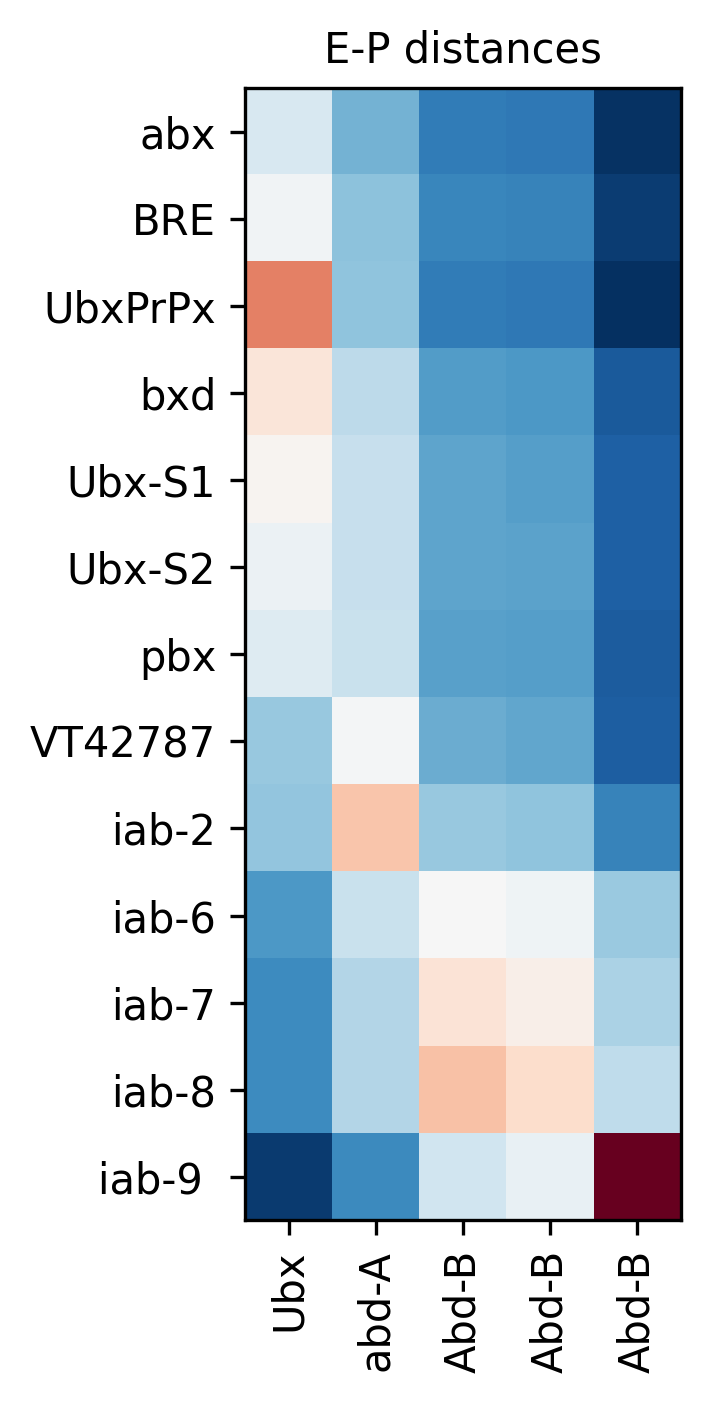

In [63]:
figure_size = 5
fig, ax = plt.subplots(figsize=(figure_size,figure_size), dpi=300)

plt.axis('on')
ax.imshow(all_median, cmap=plt.cm.RdBu)
ax.set_xticks(np.arange(len(ref_gene_parsed.gene_id.values)))
ax.set_xticklabels(ref_gene_parsed.gene_id.values)
ax.set_yticks(np.arange(len(enhancersF.enhancer.values)))
ax.set_yticklabels(enhancersF.enhancer.values)
title = f'E-P distances'
plt.xticks(rotation = 90)
ax.set_title(title, fontsize=10)
ax.set_aspect('equal')


plt.show()

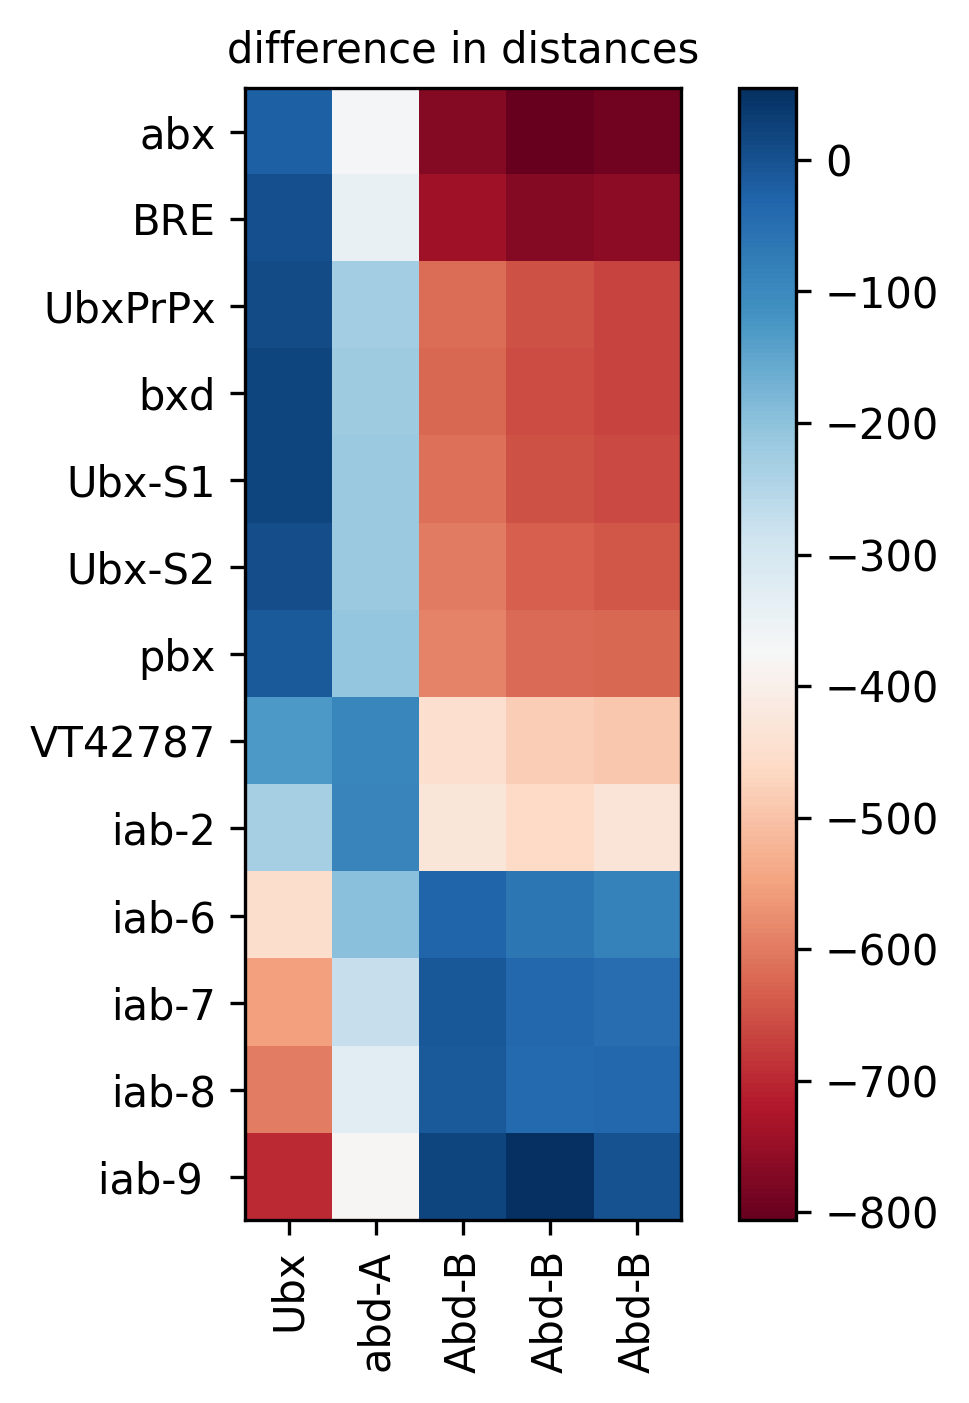

In [65]:

figure_size = 5
fig, ax = plt.subplots(figsize=(figure_size,figure_size), dpi=300)

plt.axis('on')
im = ax.imshow(pos_mean - neg_mean, cmap=plt.cm.RdBu)
ax.set_xticks(np.arange(len(ref_gene_parsed.gene_id.values)))
ax.set_xticklabels(ref_gene_parsed.gene_id.values)
ax.set_yticks(np.arange(len(enhancersF.enhancer.values)))
ax.set_yticklabels(enhancersF.enhancer.values)
title = f'difference in distances'
plt.xticks(rotation = 90)
ax.set_title(title, fontsize=10)
ax.set_aspect('equal')

fig.colorbar(im,orientation='vertical')

plt.show()

In [66]:
sliced_array_pos = pos_contact_diff[:, 1, :] # abd-A gene, 
sliced_array_neg = neg_contact_diff[:, 1, :] # abd-A gene, 

pos_mean_sliced = np.mean(sliced_array_pos, axis=(1))
neg_mean_sliced  = EP_distancenp.mean(sliced_array_neg, axis=(1))

EP_distance = pd.DataFrame([pos_mean_sliced, neg_mean_sliced]).T
EP_distance.columns = ['high_cells', 'low_cells']
EP_distance['enhancer'] = enhancersF['enhancer']

In [67]:
EP_distance

,high_cells,low_cells,enhancer
0,257.701968,630.032396,abx
1,234.273638,579.160993,BRE
2,293.234735,520.358972,UbxPrPx
3,251.756265,473.795840,bxd
4,245.945767,462.053044,Ubx-S1
5,242.410327,459.713456,Ubx-S2
6,244.013103,452.395096,pbx
7,260.681556,354.765836,VT42787
8,152.527577,245.100883,iab-2
9,262.347501,457.672462,iab-6


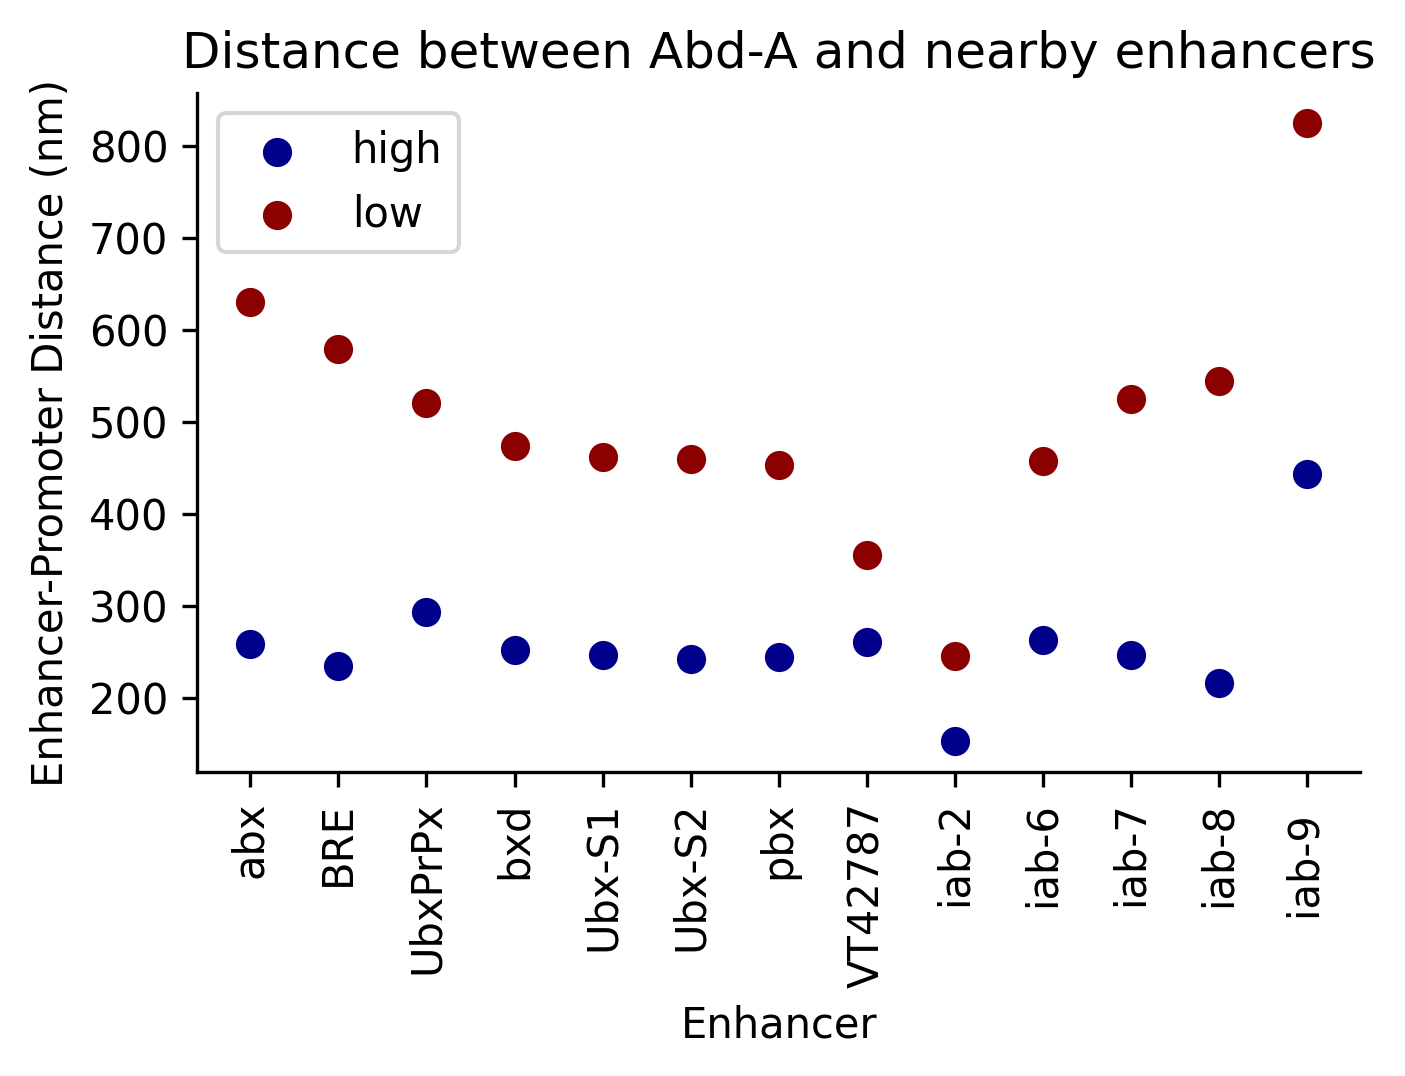

In [68]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig = plt.figure(figsize = (5,3), dpi=300)

plt.scatter(EP_distance['enhancer'], EP_distance['high_cells'], color='darkblue', label='high')
plt.scatter(EP_distance['enhancer'], EP_distance['low_cells'], color='darkred', label='low')
plt.ylabel('Enhancer-Promoter Distance (nm)')
plt.xlabel('Enhancer')
plt.title('Distance between Abd-A and nearby enhancers')
plt.xticks(rotation=90)
plt.legend()

In [73]:
nmf_reshape = chroma_factor.nmf_maps.reshape((20, 52, 52))
component_contact = np.zeros((enhancersF.shape[0], ref_gene_parsed.shape[0], nmf_reshape.shape[0]))
for i, enhancer_row in enhancersF.iterrows():
    cur_enhancer_probe = enhancer_row['bin_no']
    for j, gene_row in ref_gene_parsed.iterrows():
        cur_gene_probe = gene_row['bin_no']
        component_contact[i,j] = chroma_factor.nmf_maps[cur_enhancer_probe][cur_gene_probe]
        


In [75]:
sliced_array = component_contact[:, 1, :] # abd-A gene

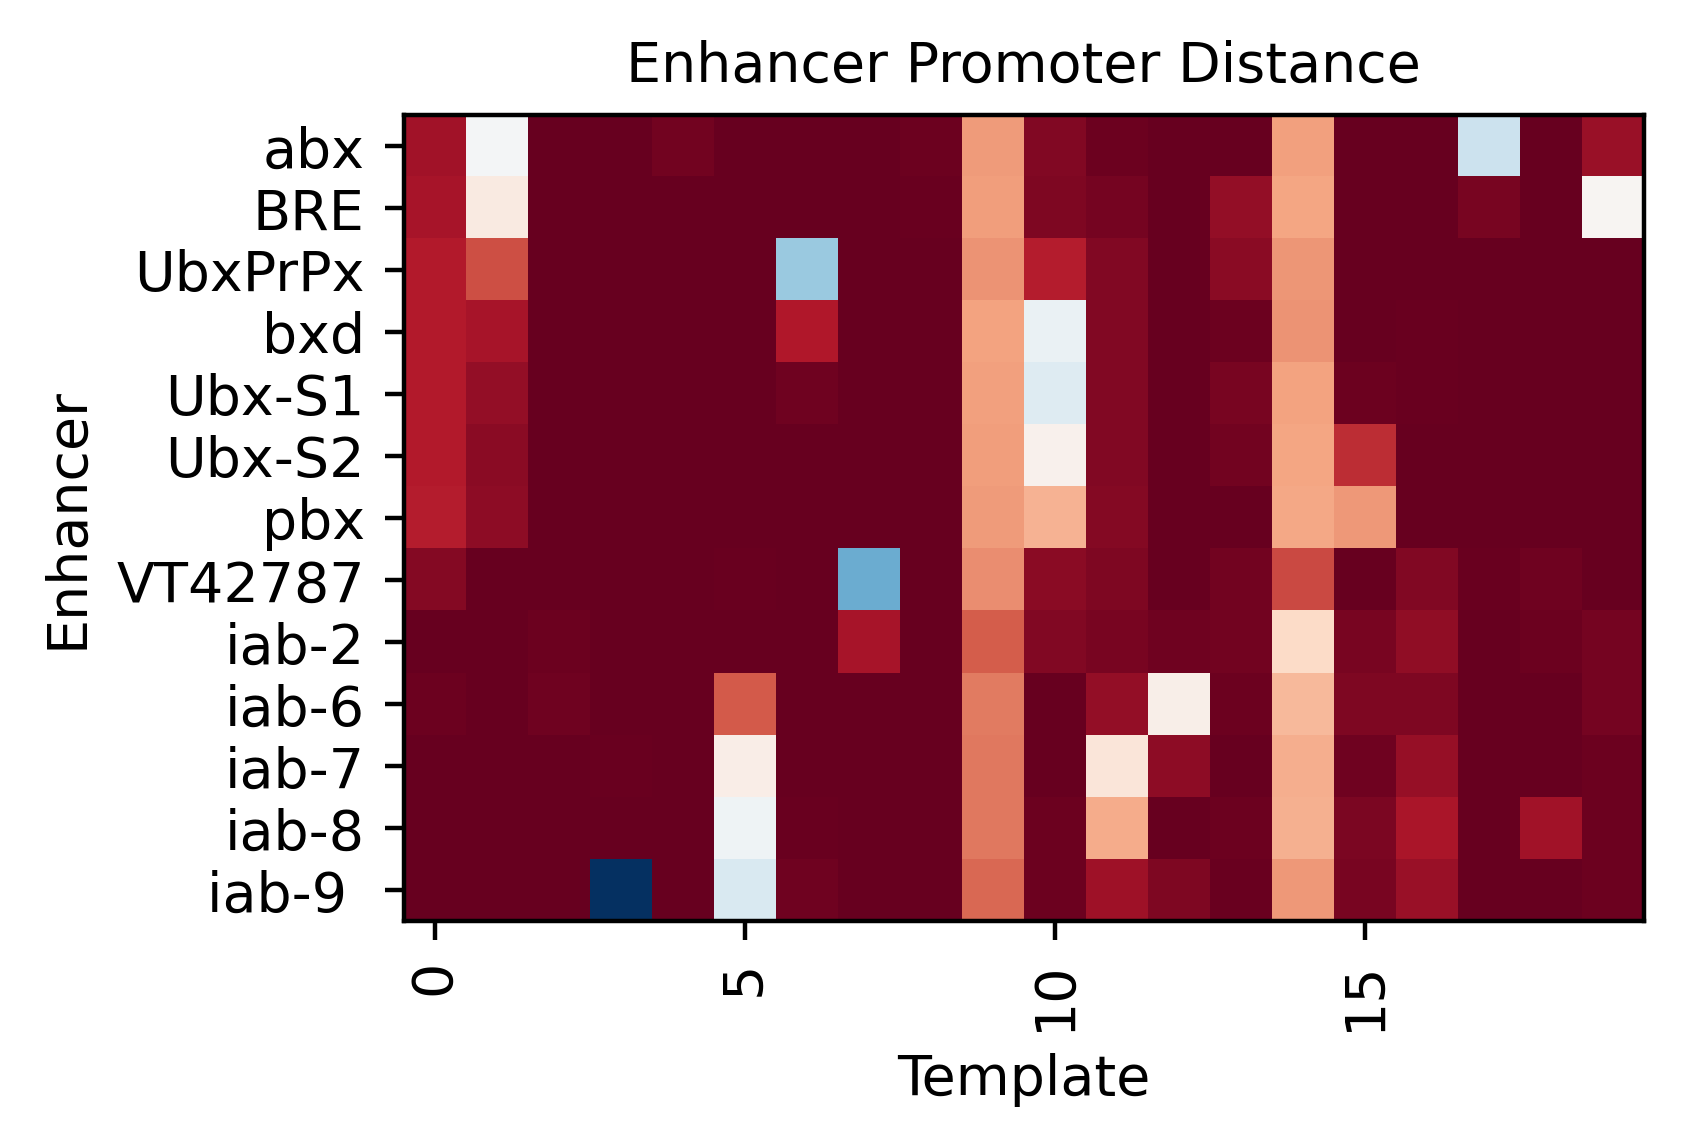

In [77]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(sliced_array, cmap=plt.cm.RdBu)

ax.set_yticks(np.arange(len(enhancersF.enhancer.values)))
ax.set_yticklabels(enhancersF.enhancer.values)
title = f'Enhancer Promoter Distance'
plt.xticks(rotation = 90)
ax.set_title(title, fontsize=10)

plt.xlabel('Template')
plt.ylabel('Enhancer')
fig.set_size_inches(4,10)
fig.set_dpi(400)
plt.show()